In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_Thomsen_dry_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_Thomsen_dry_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)

(1100, 2, 80, 250)


In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [55]:
frac_params = pd.read_csv('frac_params_Thomsen_dry.csv')
#frac_params['gamma'] *= 2.6
#frac_params['e'] *= 2.6
frac_params = np.array(frac_params[['delta','gamma','e','eps']])

In [56]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [57]:
#"""
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        #self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0, stride=2)
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(10*15*n3,50)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=50)
        self.fc2 = torch.nn.Linear(50,20)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=20)
        
        self.out = torch.nn.Linear(20,4) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
            
        x = self.out(x)
        
        return x
        
#"""

In [10]:
"""
# изменил кол-во нейронов в полносвязных слоях
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3,n4,prob=0.0):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        self.do2 = torch.nn.Dropout(p=prob)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.do3 = torch.nn.Dropout(p=prob)
        
        self.conv4 = torch.nn.Conv2d(in_channels=n3, out_channels=n4, kernel_size=2, padding=0, stride=2)
        self.ac4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=n4)
        self.do4 = torch.nn.Dropout(p=prob)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        
        self.fc1 = torch.nn.Linear(10*15*n4,200)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=100)
        self.fc2 = torch.nn.Linear(200,80)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=40)
        self.fc3 = torch.nn.Linear(80,20)
        self.ac3_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,1) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.do1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.do2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.do3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        #x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool4(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
        x = self.fc3(x)
        x = self.ac3_(x)
            
        x = self.out(x)
        
        return x
        
"""

"\n# изменил кол-во нейронов в полносвязных слоях\nclass FracAnisotropyNet(torch.nn.Module):\n    def __init__(self,n1,n2,n3,n4,prob=0.0):\n        super(FracAnisotropyNet,self).__init__()\n        \n        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)\n        self.ac1 = torch.nn.ReLU()\n        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)\n        self.do1 = torch.nn.Dropout(p=prob)\n        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)\n        \n        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))\n        self.ac2 = torch.nn.ReLU()\n        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)\n        self.do2 = torch.nn.Dropout(p=prob)\n        \n        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))\n        self.ac3 = torch.nn.ReLU()\n        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)\n     

In [58]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(4,6,2)
#neural_net = FracAnisotropyNet(4,6,4,2)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [59]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.004062795 
	Test Loss:	 0.024522332
epoch # 2 :
	Train Loss:	 0.0011039674 
	Test Loss:	 0.020209825
epoch # 3 :
	Train Loss:	 0.00048686608 
	Test Loss:	 0.01293011
epoch # 4 :
	Train Loss:	 0.00032027753 
	Test Loss:	 0.0061960495
epoch # 5 :
	Train Loss:	 0.00020909347 
	Test Loss:	 0.0015965175
epoch # 6 :
	Train Loss:	 0.00015369232 
	Test Loss:	 0.00051586056
epoch # 7 :
	Train Loss:	 0.00012588102 
	Test Loss:	 0.00018312957
epoch # 8 :
	Train Loss:	 0.00010688612 
	Test Loss:	 0.00010085272
epoch # 9 :
	Train Loss:	 9.459554e-05 
	Test Loss:	 8.150518e-05
epoch # 10 :
	Train Loss:	 8.39235e-05 
	Test Loss:	 7.698554e-05
epoch # 11 :
	Train Loss:	 7.7200275e-05 
	Test Loss:	 7.248028e-05
epoch # 12 :
	Train Loss:	 7.362696e-05 
	Test Loss:	 6.708551e-05
epoch # 13 :
	Train Loss:	 7.06126e-05 
	Test Loss:	 6.421843e-05
epoch # 14 :
	Train Loss:	 6.509215e-05 
	Test Loss:	 5.9824884e-05
epoch # 15 :
	Train Loss:	 5.9262948e-05 
	Test Loss:	 5.6055094e-0

epoch # 121 :
	Train Loss:	 8.447358e-06 
	Test Loss:	 9.923207e-06
epoch # 122 :
	Train Loss:	 8.541865e-06 
	Test Loss:	 9.522796e-06
epoch # 123 :
	Train Loss:	 8.548763e-06 
	Test Loss:	 1.0406945e-05
epoch # 124 :
	Train Loss:	 8.790497e-06 
	Test Loss:	 1.0526186e-05
epoch # 125 :
	Train Loss:	 9.292657e-06 
	Test Loss:	 1.0227981e-05
epoch # 126 :
	Train Loss:	 8.838089e-06 
	Test Loss:	 1.0518655e-05
epoch # 127 :
	Train Loss:	 8.854133e-06 
	Test Loss:	 9.589243e-06
epoch # 128 :
	Train Loss:	 8.8782135e-06 
	Test Loss:	 1.1022584e-05
epoch # 129 :
	Train Loss:	 9.106536e-06 
	Test Loss:	 9.3379485e-06
epoch # 130 :
	Train Loss:	 7.931815e-06 
	Test Loss:	 9.181773e-06
epoch # 131 :
	Train Loss:	 9.789893e-06 
	Test Loss:	 1.0588809e-05
epoch # 132 :
	Train Loss:	 8.578139e-06 
	Test Loss:	 8.948746e-06
epoch # 133 :
	Train Loss:	 8.065595e-06 
	Test Loss:	 9.72346e-06
epoch # 134 :
	Train Loss:	 8.752451e-06 
	Test Loss:	 1.102106e-05
epoch # 135 :
	Train Loss:	 8.070429e-06 

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

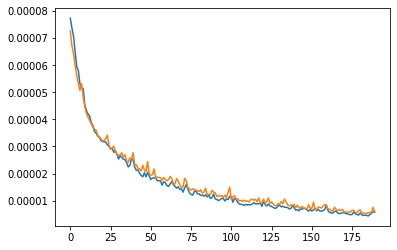

In [61]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

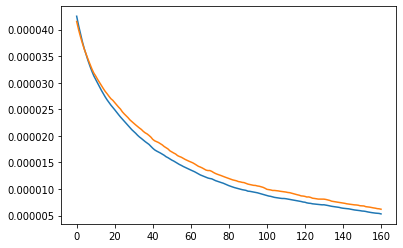

In [62]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [63]:
print('Train Loss: ', avg_loss_train[-1])
print('Test Loss:  ', avg_loss_test[-1])

Train Loss:  5.3069844094958775e-06
Test Loss:   6.188956528300575e-06


In [47]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\tReal value\tDifference')
sum_delta = 0.0
sum_gamma = 0.0
sum_e = 0.0
sum_eps = 0.0
sum_delta_sq = 0.0
sum_gamma_sq = 0.0
sum_e_sq = 0.0
sum_eps_sq = 0.0
sum_delta_real = 0.0
sum_gamma_real = 0.0
sum_e_real = 0.0
sum_eps_real = 0.0
for i in range(300):
    # gamma
    #pred[i][1] /= 2.6
    #y_val[i][1] /= 2.6
    
    # e
    #pred[i][2] /= 2.6
    #y_val[i][2] /= 2.6
    
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\t',y_val[i],'\t',dif)
    
    sum_delta += dif[0]
    sum_gamma += dif[1]
    sum_e += dif[2]
    sum_eps += dif[3]
    
    sum_delta_sq += dif[0]**2
    sum_gamma_sq += dif[1]**2
    sum_e_sq += dif[2]**2
    sum_eps_sq += dif[3]**2
    
    sum_delta_real += y_val[i][0]
    sum_gamma_real += y_val[i][1]
    sum_e_real += y_val[i][2]
    sum_eps_real += y_val[i][3]

mean_delta_sq = sum_delta_sq/300
mean_gamma_sq = sum_gamma_sq/300
mean_e_sq = sum_e_sq/300
mean_eps_sq = sum_eps_sq/300

Predicted	Real value	Difference
[-0.23146388 -0.08769175  0.07931071 -0.21330574] 	 [-0.22807468 -0.08887267  0.07981878 -0.21285006] 	 [0.00338919 0.00118092 0.00050807 0.00045568]
[-0.1357674  -0.05118682  0.04557329 -0.12110125] 	 [-0.13359757 -0.05205827  0.04675483 -0.12467957] 	 [0.00216983 0.00087145 0.00118155 0.00357831]
[-0.089743   -0.03607501  0.03086942 -0.08267059] 	 [-0.09237926 -0.03599694  0.03232975 -0.08621268] 	 [2.6362613e-03 7.8063458e-05 1.4603324e-03 3.5420880e-03]
[-0.21206027 -0.08434577  0.07333997 -0.19973806] 	 [-0.21184179 -0.08254728  0.07413778 -0.19770075] 	 [0.00021848 0.00179849 0.00079782 0.0020373 ]
[-0.10633583 -0.04236988  0.03513803 -0.09458203] 	 [-0.10404179 -0.04054142  0.03641127 -0.09709671] 	 [0.00229403 0.00182845 0.00127324 0.00251468]
[-0.07127752 -0.02696261  0.02340417 -0.06285771] 	 [-0.06927504 -0.02699405  0.02424403 -0.06465074] 	 [2.0024776e-03 3.1434000e-05 8.3985552e-04 1.7930269e-03]
[-0.01517989 -0.00691368  0.00496793 -0.0182

[-0.15415367 -0.05879255  0.05398111 -0.14504552] 	 [-0.15576556 -0.06069636  0.05451292 -0.14536777] 	 [0.00161189 0.00190381 0.00053181 0.00032225]
[-0.20649683 -0.08103008  0.07066377 -0.19144434] 	 [-0.20494826 -0.07986113  0.07172527 -0.1912674 ] 	 [0.00154857 0.00116895 0.00106151 0.00017694]
[-0.18277729 -0.07115702  0.06267996 -0.16722733] 	 [-0.18070136 -0.07041296  0.06323964 -0.16863903] 	 [0.00207593 0.00074405 0.00055968 0.00141171]
[-0.0464273  -0.02010744  0.01591244 -0.04448437] 	 [-0.04937614 -0.01924014  0.01728005 -0.04608015] 	 [0.00294884 0.0008673  0.00136761 0.00159578]
[-0.24618474 -0.09334794  0.08511917 -0.22857055] 	 [-0.24507284 -0.09549627  0.08576758 -0.22871354] 	 [0.00111189 0.00214832 0.00064841 0.00014299]
[-0.19657132 -0.07672864  0.06806682 -0.18222442] 	 [-0.1962725  -0.07648049  0.06868903 -0.18317077] 	 [0.00029881 0.00024816 0.00062221 0.00094634]
[-0.2613681  -0.10298026  0.0912061  -0.24978814] 	 [-0.26223338 -0.10218312  0.09177321 -0.24472857

In [48]:
print('Mean epsilon difference: ', sum_eps/300)
print('Mean delta difference: ', sum_delta/300)
print('Mean gamma difference: ', sum_gamma/300)
print('Mean e (crack density) difference: ', sum_e/300)

print('\nEpsilon MSE: ', math.sqrt(mean_eps_sq))
print('Delta MSE: ', math.sqrt(mean_delta_sq))
print('Gamma MSE: ', math.sqrt(mean_gamma_sq))
print('e MSE: ', math.sqrt(mean_e_sq))

#print(mean_asp_real)
print('\nRelative epsilon accuracy: ', sum_eps/abs(sum_eps_real))
print('Relative delta accuracy: ', sum_delta/abs(sum_delta_real))
print('Relative gamma accuracy: ', sum_gamma/abs(sum_gamma_real))
print('Relative e (crack density) accuracy: ', sum_e/sum_e_real)
#print('Mean dn difference: ', sum_dn/300)
#print('dn MSE: ', math.sqrt(sum_dn_sq/300))
#print('\nRelative dn accuracy: ', sum_dn/sum_dn_real)

Mean epsilon difference:  0.002120545630265648
Mean delta difference:  0.0021529629974005125
Mean gamma difference:  0.0009926827667125812
Mean e (crack density) difference:  0.0006975994308595546

Epsilon MSE:  0.002696581472523335
Delta MSE:  0.0027739506494834656
Gamma MSE:  0.001247256003453881
e MSE:  0.0008390448655865025

Relative epsilon accuracy:  0.01591823030076226
Relative delta accuracy:  0.015082746259263648
Relative gamma accuracy:  0.01784691529812005
Relative e (crack density) accuracy:  0.013964391290996712


In [49]:
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
g = (Vs**2)/(Vp**2)
print('e (crack density)\tDelta formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = -8*e_pred/3 * ( 1 + g*(1-2*g)/( (3-2*g)*(1-g) ) )
    delta_pred = pred[i][0]
    dif = abs(delta_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',delta_pred,'\t',dif)

e (crack density)	Delta formula	Predicted value	Difference
0.07931071 	 -0.22662293456857244 	 -0.23146388 	 0.004840944778275097
0.045573287 	 -0.13022140724643272 	 -0.1357674 	 0.005545993018307271
0.03086942 	 -0.08820648418717124 	 -0.089742996 	 0.0015365116114165606
0.07333997 	 -0.20956210642559844 	 -0.21206027 	 0.00249816626803559
0.03513803 	 -0.10040363540046367 	 -0.106335826 	 0.005932190817664537
0.02340417 	 -0.06687522779838705 	 -0.07127752 	 0.004402293752268319
0.004967927 	 -0.014195387076378636 	 -0.015179887 	 0.0009845003375999403
0.08788605 	 -0.2511261745360806 	 -0.25658482 	 0.005458648595480675
0.05098429 	 -0.14568284196197331 	 -0.14552733 	 0.0001555089408093735
0.056863043 	 -0.16248083194191437 	 -0.16232675 	 0.00015407880241852245
0.07699292 	 -0.2200000770874786 	 -0.22248441 	 0.002484332721633953
0.07554366 	 -0.21585893898941655 	 -0.2160733 	 0.00021436542533259662
0.068663165 	 -0.19619857626867374 	 -0.19832009 	 0.0021215145020477
0.0351943 

0.006549152 	 -0.018713589948227527 	 -0.020164646 	 0.0014510562600587584
0.058643453 	 -0.16756818529796114 	 -0.16769153 	 0.00012334349918852183
0.00750995 	 -0.02145898043962906 	 -0.022351667 	 0.0008926868453364538
0.041897222 	 -0.11971739705906026 	 -0.121517904 	 0.0018005070437420168
0.021550652 	 -0.061578972816326946 	 -0.06428041 	 0.0027014402748557625
0.0022018184 	 -0.006291490270643297 	 -0.005444072 	 0.0008474180836964282
0.075139344 	 -0.21470365179071704 	 -0.21779779 	 0.0030941342066737043
0.030239606 	 -0.08640684857182704 	 -0.0884332 	 0.0020263500589827455
0.067627415 	 -0.19323901770134957 	 -0.19985521 	 0.006616190695562046
0.036788788 	 -0.1051205223468217 	 -0.108749844 	 0.003629321787032208
0.022942604 	 -0.0655563480065978 	 -0.07000635 	 0.004450000186093997
0.05474806 	 -0.15643745958787986 	 -0.15406674 	 0.00237071812135764
0.09556074 	 -0.27305587420713073 	 -0.27383143 	 0.0007755528901898234
0.09799876 	 -0.28002229901975095 	 -0.28475064 	 0.

In [50]:
print('Mean difference between predicted value and formula for delta: ', sum_dif/300)
print('Relative difference between predicted value and formula for delta: ', sum_dif/abs(sum_delta_real))

Mean difference between predicted value and formula for delta:  0.002803446429346245
Relative difference between predicted value and formula for delta:  0.01963975748599554


In [51]:
print('e (crack density)\tGamma formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = -8*e_pred/(3*(3-2*g))
    gamma_pred = pred[i][1]
    dif = abs(gamma_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',gamma_pred,'\t',dif)

e (crack density)	Gamma formula	Predicted value	Difference
0.07931071 	 -0.08830698148691579 	 -0.08769175 	 0.0006152348347894798
0.045573287 	 -0.05074269919239487 	 -0.051186822 	 0.0004441231623986755
0.03086942 	 -0.03437096241371616 	 -0.036075007 	 0.001704044756722603
0.07333997 	 -0.08165897722449995 	 -0.08434577 	 0.002686795637934433
0.03513803 	 -0.03912376295632592 	 -0.042369876 	 0.0032461131005836405
0.02340417 	 -0.02605892256389663 	 -0.026962612 	 0.0009036892603774341
0.004967927 	 -0.0055314427294827365 	 -0.0069136834 	 0.001382240647723589
0.08788605 	 -0.09785503169771856 	 -0.09862117 	 0.0007661355448084495
0.05098429 	 -0.05676747612764044 	 -0.056224678 	 0.0005427984159152022
0.056863043 	 -0.06331306160865098 	 -0.06358305 	 0.0002699920398208516
0.07699292 	 -0.0857262870215175 	 -0.084994495 	 0.0007317921065089494
0.07554366 	 -0.08411263125425589 	 -0.08337856 	 0.0007340704131723608
0.068663165 	 -0.07645167985888264 	 -0.078599885 	 0.00214820524720

0.0022018184 	 -0.0024515723261305583 	 -0.0017642616 	 0.0006873106966981185
0.075139344 	 -0.08366245649386879 	 -0.08591631 	 0.0022538540549135594
0.030239606 	 -0.03366970775354713 	 -0.0345006 	 0.0008308911539235755
0.067627415 	 -0.0752984440484309 	 -0.07896881 	 0.003670364006493107
0.036788788 	 -0.0409617677859822 	 -0.041848995 	 0.0008872270055255219
0.022942604 	 -0.025545001527710595 	 -0.02561944 	 7.44382530015325e-05
0.05474806 	 -0.06095817210198112 	 -0.060039394 	 0.0009187784981793956
0.09556074 	 -0.10640026383210821 	 -0.10791615 	 0.0015158826846917162
0.09799876 	 -0.10911483439456778 	 -0.10820267 	 0.0009121608997519487
0.004129639 	 -0.004598066967729901 	 -0.006315969 	 0.001717901962991382
0.040969614 	 -0.045616828325148163 	 -0.04549629 	 0.00012053963815742558
0.013374646 	 -0.014891742457095831 	 -0.018008653 	 0.003116910617407114
0.090575166 	 -0.10084917583478849 	 -0.10029869 	 0.0005504880191222888
0.01578563 	 -0.017576206866949898 	 -0.0166318

In [52]:
print('Mean difference between predicted value and formula for gamma: ', sum_dif/300)
print('Relative difference between predicted value and formula for gamma: ', sum_dif/abs(sum_gamma_real))

Mean difference between predicted value and formula for gamma:  0.0012126016108421067
Relative difference between predicted value and formula for gamma:  0.02180071918718918


In [53]:
print('e (crack density)\tEpsilon formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = -8*e_pred/3
    eps_pred = pred[i][3]
    dif = abs(eps_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',eps_pred,'\t',dif)

e (crack density)	Epsilon formula	Predicted value	Difference
0.07931071 	 -0.21149522066116333 	 -0.21330574 	 0.001810520887374878
0.045573287 	 -0.12152876456578572 	 -0.12110125 	 0.000427511831124619
0.03086942 	 -0.08231845498085022 	 -0.08267059 	 0.0003521367907524109
0.07333997 	 -0.1955732504526774 	 -0.19973806 	 0.004164805014928191
0.03513803 	 -0.09370141228040059 	 -0.09458203 	 0.0008806164065996852
0.02340417 	 -0.06241111954053243 	 -0.06285771 	 0.0004465902845064776
0.004967927 	 -0.013247805337111155 	 -0.018230356 	 0.004982550938924154
0.08788605 	 -0.23436280091603598 	 -0.23364776 	 0.0007150371869405203
0.05098429 	 -0.13595810532569885 	 -0.1362459 	 0.00028780102729797363
0.056863043 	 -0.15163478255271912 	 -0.152872 	 0.0012372136116027832
0.07699292 	 -0.20531445741653442 	 -0.20554024 	 0.0002257823944091797
0.07554366 	 -0.20144975185394287 	 -0.20154676 	 9.700655937194824e-05
0.068663165 	 -0.18310177326202393 	 -0.18657565 	 0.0034738779067993164
0.03

In [54]:
print('Mean difference between predicted value and formula for epsilon: ', sum_dif/300)
print('Relative difference between predicted value and formula for epsilon: ', sum_dif/abs(sum_eps_real))

Mean difference between predicted value and formula for epsilon:  0.0025122790468028837
Relative difference between predicted value and formula for epsilon:  0.018858842684643374
